# CSE 252A Computer Vision I Fall 2019 - Homework 3
## Instructor: Ben Ochoa
### Assignment published on: Tuesday, October 22, 2019
### Due on: Tuesday, November 5, 2019 11:59 pm

## Instructions
* Review the academic integrity and collaboration policies on the course website.
  * This assignment must be completed individually.
* All solutions must be written in this notebook.
  * This includes the theoretical problems, for which you **must** write your answers in Markdown cells (using LaTeX when appropriate).
  * Programming aspects of the assignment must be completed using Python in this notebook.
* If you want to modify the skeleton code, you may do so. It has only been provided as a framework for your solution.
* You may use Python packages (such as NumPy and SciPy) for basic linear algebra, but you may not use packages that directly solve the problem.
  * If you are unsure about using a specific package or function, then ask the instructor and/or teaching assistants for clarification.
* You must submit this notebook exported as a PDF. You must also submit this notebook as `.ipynb` file.
  * Submit both files (`.pdf` and `.ipynb`) on Gradescope.
  * **You must mark the PDF pages associated with each question in Gradescope. If you fail to do so, we may dock points.**
* It is highly recommended that you begin working on this assignment early.
* **Late policy: assignments submitted late will receive a 15% grade reduction for each 12 hours late (i.e., 30% per day). Assignments will not be accepted 72 hours after the due date. If you require an extension (for personal reasons only) to a due date, you must request one as far in advance as possible. Extensions requested close to or after the due date will only be granted for clear emergencies or clearly unforeseeable circumstances.**

## Problem 1: Photometric Stereo, Specularity Removal [20 pts]

The goal of this problem is to implement a couple of different algorithms that reconstruct a surface using the concept of Lambertian photometric stereo. Additionally, you will implement the specular removal technique of [Mallick et al.](http://www.eecs.harvard.edu/~zickler/download/photodiff_cvpr05_preprint.pdf), which enables photometric stereo to be performed on certain non-Lambertian materials.

You can assume a Lambertian reflectance function once specularities are removed. However, note that the albedo is unknown and non-constant in the images you will use.

As input, your program should take in multiple images along with the light source direction for each image. Each image is associated with only a single light, and hence a single direction.

### Data
You will use synthetic images and specular sphere images as data. These images are stored in `.pickle` files which have been graciously provided by Satya Mallick. Each `.pickle` file contains

* `im1`, `im2`, `im3`, `im4`, ... images.
* `l1`, `l2`, `l3`, `l4`, ... light source directions.

### Part 1: Lambertian Photometric Stereo [8 pts]

Implement the photometric stereo technique described in the lecture slides and in Forsyth and Ponce 2.2.4 (*Photometric Stereo: Shape from Multiple Shaded Images*). Your program should have two parts:

1. Read in the images and corresponding light source directions, and estimate the surface normals and albedo map.

1. Reconstruct the depth map from the surface normals. You should first try the naive scanline-based "shape by integration" method described in the book and in lecture. (You are required to implement this.) For comparison, you should also integrate using the Horn technique which is already implemented for you in the `horn_integrate` function. Note that for good results you will often want to run the `horn_integrate` function with 10000-100000 iterations, which will take a while. For your final submission, we will require that you run Horn integration for 1000 (one thousand) iterations or more in each case. But for debugging, it is suggested that you keep the number of iterations low.

You will find all the data for this part in `synthetic_data.pickle`. Try using only `im1`, `im2` and `im4` first. Display your outputs as mentioned below.

Then use all four images (most accurate).

For **each** of the **two above cases** you must output:

1. The estimated albedo map.

1. The estimated surface normals by showing both
    1. Needle map, and
    1. Three images showing each of the surface normal components.

1. A wireframe of the depth map given by the scanline method.

1. A wireframe of the depth map given by Horn integration.

In total, we expect 2 * 7 = 14 images for this part.

An example of outputs is shown in the figure below. (The example outputs only include one depth map, although we expect two – see above.)

![Problem 1.1 example outputs](problem1_example.png)

Keys:  ['__version__', 'l4', '__header__', 'im1', 'im3', 'im2', 'l2', 'im4', 'l1', '__globals__', 'l3']

Image 1:


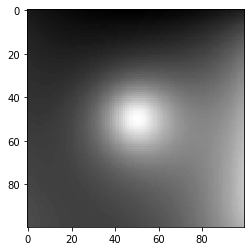

Light source direction: [[0 0 1]]

Image 2:


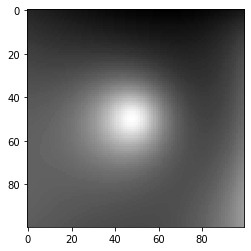

Light source direction: [[0.2 0.  1. ]]

Image 3:


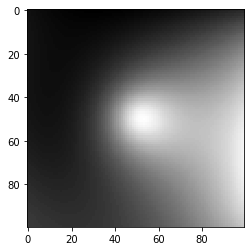

Light source direction: [[-0.2  0.   1. ]]

Image 4:


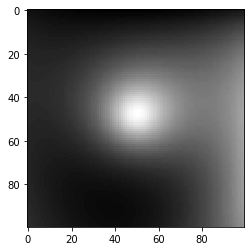

Light source direction: [[0.  0.2 1. ]]


In [1]:
# Setup
import pickle
import numpy as np
from time import time
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt

### Example: how to read and access data from a .pickle file
pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

# data is a dict which stores each element as a key-value pair. 
print("Keys: ", list(data.keys()))

# To access the value of an entity, refer to it by its key.
for i in range(1, 5):
    print("\nImage %d:" % i)
    plt.imshow(data["im%d" % i], cmap="gray")
    plt.show()
    print("Light source direction: " + str(data["l%d" % i]))

Based on the above images, can you interpret the orientation of the coordinate frame? If we label the axes in order as x, y, z, then the x-axis points left, the y-axis points up, and the z-axis points out of the screen in our direction. (That means this is a left-handed coordinate system. How will this affect the scanline integration algorithm? Hint: if you integrate rightward along the x-axis and downward along the y-axis, you will be doing in opposite directions to the axes, and the partial derivatives you compute may need to be modified.)

_Note: as clarification, no direct response is needed for this cell._

In [2]:
import numpy as np
from scipy.signal import convolve

def horn_integrate(gx, gy, mask, niter):
    """
    horn_integrate recovers the function g from its partial 
    derivatives gx and gy. 
    mask is a binary image which tells which pixels are 
    involved in integration. 
    niter is the number of iterations. 
    typically 100,000 or 200,000, 
    although the trend can be seen even after 1000 iterations.
    """
    g = np.ones(np.shape(gx))
    
    gx = np.multiply(gx, mask)
    gy = np.multiply(gy, mask)
    
    A = np.array([[0,1,0],[0,0,0],[0,0,0]]) #y-1
    B = np.array([[0,0,0],[1,0,0],[0,0,0]]) #x-1
    C = np.array([[0,0,0],[0,0,1],[0,0,0]]) #x+1
    D = np.array([[0,0,0],[0,0,0],[0,1,0]]) #y+1
    
    d_mask = A + B + C + D
    
    den = np.multiply(convolve(mask,d_mask,mode="same"),mask)
    den[den == 0] = 1
    rden = 1.0 / den
    mask2 = np.multiply(rden, mask)
    
    m_a = convolve(mask, A, mode="same")
    m_b = convolve(mask, B, mode="same")
    m_c = convolve(mask, C, mode="same")
    m_d = convolve(mask, D, mode="same")
    
    term_right = np.multiply(m_c, gx) + np.multiply(m_d, gy)
    t_a = -1.0 * convolve(gx, B, mode="same")
    t_b = -1.0 * convolve(gy, A, mode="same")
    term_right = term_right + t_a + t_b
    term_right = np.multiply(mask2, term_right)
    
    for k in range(niter):
        g = np.multiply(mask2, convolve(g, d_mask, mode="same")) + term_right
    
    return g

In [3]:
def photometric_stereo(images, lights, mask, reverse_derivative, horn_niter=1000):
    
    """mask is an optional parameter which you are encouraged to use.
    It can be used e.g. to ignore the background when integrating the normals.
    It should be created by converting the images to grayscale, averaging them,
    normalizing to [0, 1] and thresholding (only using locations for which the
    pixel value is above some threshold).
    
    The choice of threshold is something you can experiment with,
    but in practice something like 0.05 or 0.1 tends to work well.
    
    You do not need to use the mask for 1a (it shouldn't matter),
    but you SHOULD use it to filter out the background for the specular data (1c).
    """

    """ ==========
    YOUR CODE HERE
    ========== """


    # note:
    # images : (n_ims, h, w)
    # lights : (n_ims, 3)
    # mask   : (h, w)

    albedo = np.ones(images[0].shape)
    normals = np.dstack((np.zeros(images[0].shape),
                         np.zeros(images[0].shape),
                         np.ones(images[0].shape)))
    H = np.ones(images[0].shape)
    H_horn = np.ones(images[0].shape)
    
    # ps is gx, qs is gy
    ps = np.zeros_like(H)
    qs = np.zeros_like(H)
   
    for row_idx in range(albedo.shape[0]):
        for col_idx in range(albedo.shape[1]):
            
            # Algorithm taken from page 48 of Jean Ponce book
            
            # V is a matrix, each row should represents one light source
            # i_xy is a column vector, where each entry represents the 
            # values of one images at coordinate xy
            
            # then i_xy = V g_xy
            # we need to solve for g_xy.
            # After solving for g_xy,
            # the albedo is the magnitude of g_xy.
            # the normal is g_xy / |g_xy|
            
            i_xy = images[:, row_idx, col_idx]
            
            # i_xy is currently a row vector, 
            # we turn it into a column vector
            i_xy = np.expand_dims(i_xy, axis=1)
            
            V = lights
                        
            # lstsq(a, b) solves for x in ax = b
            g_xy, *_ = np.linalg.lstsq(V, i_xy)
            norm_gxy = np.sqrt(np.sum(g_xy ** 2))
            
            albedo[row_idx, col_idx] = norm_gxy
            normals[row_idx, col_idx] = N = g_xy.flatten() / norm_gxy
                        
            ps[row_idx, col_idx] = N[0] / N[2]
            qs[row_idx, col_idx] = N[1] / N[2]
    
    if reverse_derivative:
        # Since the images are defined wrt to the left-handed coordinate system,
        # and the algorithm for calculating the normal was defined wrt the right-handed coordinate system,
        # we need to reverse the direction of the derivatives that were calculated from the algorithm.
        ps = - ps 
        qs = - qs

    # Perform scanline intergration below.
    H[row_idx, col_idx] = 0.0
    
    # mask is a matrix of 0, 1 
    # where if an entry is 0 
    # then the height at that point is set to 0.
    
    # First process in the left most column of the heightmap
    for row_idx in range(1, H.shape[0]):
        
        # height value = prev height value + corresponding q value
        H[row_idx, 0] = (H[row_idx - 1, 0] + qs[row_idx, col_idx]) * mask[row_idx, 0]

    # For each row...
    for row_idx in range(H.shape[0]):
        
        # for each element of the row each for leftmost...
        for col_idx in range(1, H.shape[1]):
            
            # height value = prev height value + corresponding p value
            H[row_idx, col_idx] = (H[row_idx, col_idx - 1] + ps[row_idx, col_idx]) * mask[row_idx, col_idx]
    
    # Adjust H so that there is no negative depth
    if np.min(H) < 0:
        b_mask = mask.astype(np.bool)
        H[b_mask] = H[b_mask] + np.abs(np.min(H))
            
    H_horn = horn_integrate(ps, qs, mask, horn_niter)
    
    return albedo, normals, H, H_horn


In [4]:
from mpl_toolkits.mplot3d import Axes3D


def visualize(albedo, normals, depth, horn):
    # Stride in the plot, you may want to adjust it to different images
    stride = 15

    # showing albedo map
    fig = plt.figure()
    albedo_max = albedo.max()
    albedo = albedo / albedo_max
    plt.imshow(albedo, cmap="gray")
    plt.show()

    # showing normals as three separate channels
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normals[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normals[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normals[..., 2])
    plt.show()

    # showing normals as quiver
    X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], 15),
                          np.arange(0,np.shape(normals)[1], 15),
                          np.arange(1))
    X = X[..., 0]
    Y = Y[..., 0]
    Z = depth[::stride,::stride].T
    NX = normals[..., 0][::stride,::-stride].T
    NY = normals[..., 1][::-stride,::stride].T
    NZ = normals[..., 2][::stride,::stride].T
    fig = plt.figure(figsize=(5, 5))
    ax = fig.gca(projection='3d')
    plt.quiver(X,Y,Z,NX,NY,NZ, length=10)
    plt.show()

    # plotting wireframe depth map
    H = depth[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()

    H = horn[::stride,::stride]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()

/home/quan/miniconda3/envs/cse252a/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[0.19211684 0.18498002 0.18892846 ... 0.21707219 0.21707219 0.21386036]
 [0.19533191 0.19211684 0.19211684 ... 0.22308177 0.23070692 0.22612868]
 [0.19533191 0.19533191 0.20935447 ... 0.23663019 0.24282079 0.23963319]
 ...
 [0.3285938  0.3285938  0.33952727 ... 0.60207253 0.60776722 0.62314699]
 [0.31849323 0.3285938  0.3285938  ... 0.59924339 0.60491386 0.61063242]
 [0.31849323 0.3285938  0.31541215 ... 0.57743016 0.5927409  0.60776722]]


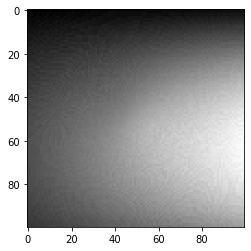

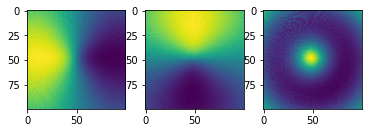

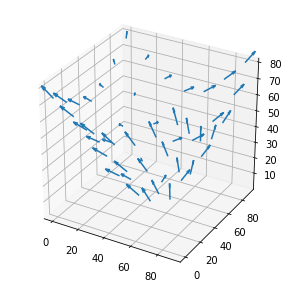

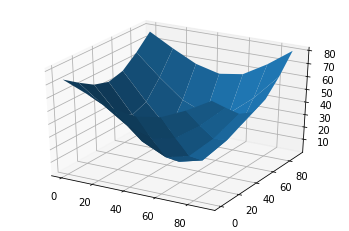

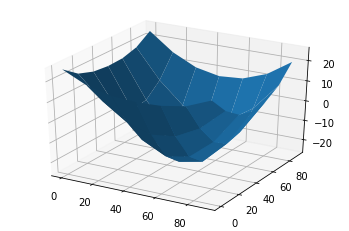

In [5]:
# PLOT FOR IM1, IM2, IM4
pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im4"])

images = np.array(images, dtype=np.float32)

# normalize images to be in range 0 and 1
images = images / 255.0

mask = np.ones(data["im1"].shape)

albedo, normals, depth, horn = photometric_stereo(images, lights, mask, reverse_derivative=True)

# We print the albedo to make sure it is between 0 and 1
# as a sanity check
print(albedo)
    
visualize(albedo, normals, depth, horn)

/home/quan/miniconda3/envs/cse252a/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[0.19799607 0.20196078 0.19493019 ... 0.21037631 0.21037631 0.20264495]
 [0.20736987 0.19799607 0.20439446 ... 0.21647706 0.22779348 0.21956893]
 [0.20736987 0.20736987 0.21624902 ... 0.23374672 0.23500708 0.23676465]
 ...
 [0.32752146 0.32752146 0.33735183 ... 0.56722235 0.5731918  0.5796118 ]
 [0.31812013 0.32752146 0.32752146 ... 0.56425483 0.5702014  0.56787606]
 [0.31812013 0.32752146 0.31506796 ... 0.54343407 0.55868552 0.56483937]]


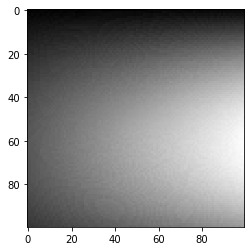

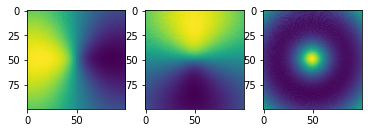

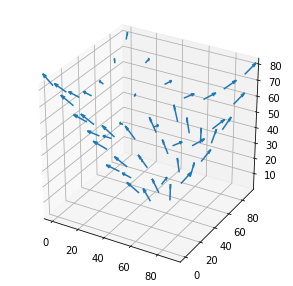

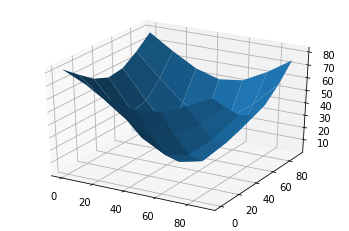

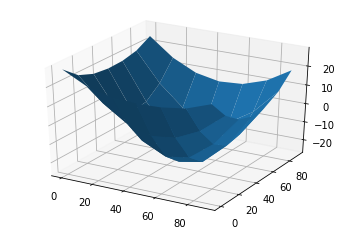

In [6]:
# PLOT FOR IM1, IM2, IM3, IM4

pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im3"])
images.append(data["im4"])

images = np.array(images, dtype=np.float32)

# normalize images to be in range 0 and 1
images = images / 255.0

mask = np.ones(data["im1"].shape)

albedo, normals, depth, horn = photometric_stereo(images, lights, mask, reverse_derivative=True)

# We print the albedo to make sure it is between 0 and 1
# as a sanity check
print(albedo)

visualize(albedo, normals, depth, horn)

### Part 2: Specularity Removal [6 pts]

Implement the specularity removal technique described in *Beyond Lambert: Reconstructing Specular Surfaces Using Color* (by Mallick, Zickler, Kriegman, and Belhumeur; CVPR 2005).

Your program should input an RGB image and light source color and output the corresponding SUV image.  

Try this out first with the specular sphere images and then with the pear images.  
  
For each of the specular sphere and pear images, include

1. The original image (in RGB colorspace).

1. The recovered $S$ channel of the image.

1. The recovered diffuse part of the image. Use $G = \sqrt{U^2+V^2}$ to represent the diffuse part.

In total, we expect 2 * 3 = 6 images as outputs for this problem.

Note: You will find all the data for this part in `specular_sphere.pickle` and `specular_pear.pickle`.

In [7]:
def get_rot_mat(rot_v, unit=None):
    '''
    Takes a vector and returns the rotation matrix required to align the
    unit vector(2nd arg) to it.
    '''
    if unit is None:
        unit = [1.0, 0.0, 0.0]
    
    rot_v = rot_v/np.linalg.norm(rot_v)
    uvw = np.cross(rot_v, unit) # axis of rotation

    rcos = np.dot(rot_v, unit) # cos by dot product
    rsin = np.linalg.norm(uvw) # sin by magnitude of cross product

    # normalize and unpack axis
    if not np.isclose(rsin, 0):
        uvw = uvw/rsin
    u, v, w = uvw

    # compute rotation matrix 
    R = (
        rcos * np.eye(3) +
        rsin * np.array([
            [ 0, -w,  v],
            [ w,  0, -u],
            [-v,  u,  0]
        ]) +
        (1.0 - rcos) * uvw[:,None] * uvw[None,:]
    )
    return R

def RGBToSUV(I_rgb, rot_vec):
    '''
    Your implementation which takes an RGB image and a vector encoding
    the orientation of the S channel w.r.t. to RGB.
    '''

    """ ==========
    YOUR CODE HERE
    ========== """

    S = np.ones(I_rgb.shape[:2])
    G = np.ones(I_rgb.shape[:2])
    
    # Given S, we need to find R such that [R] S = [1 0 0]^T
    # After we find R, we can rotate the coordinate axes of RGB to get 
    # the coordinate axes of SUV space. I_SUV = [R] I.
    
    # Given the RGB value of a pixel, we can get its corresponding point in 
    # the SUV space with R.
    
    R = get_rot_mat(rot_vec, [1.0, 0.0, 0.0])
    
    # for each row...
    for r_i in range(S.shape[0]):
        
        # for each col...
        for c_i in range(S.shape[1]):
            
            # we transform the corresponding pixel
            # to SUV coordinate 
            i_suv = np.matmul(R, I_rgb[r_i, c_i])
            
            S[r_i, c_i] = i_suv[0]
            G[r_i, c_i] = np.sqrt(np.sum(i_suv[1:] ** 2))
        
    return S, G


def plot_specularity_removal(I_rgb, rot_vec):

    S, G = RGBToSUV(data["im1"], np.hstack((data["c"][0][0],
                                            data["c"][1][0],
                                            data["c"][2][0])))

    plt.clf()
    plt.imshow(I_rgb * 255.0)
    plt.title('Original Image')
    plt.show()

    plt.clf()
    plt.imshow(S)
    plt.title('S')
    plt.show()

    plt.clf()
    plt.imshow(G)
    plt.title('G')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


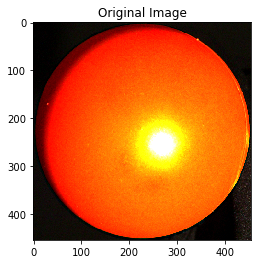

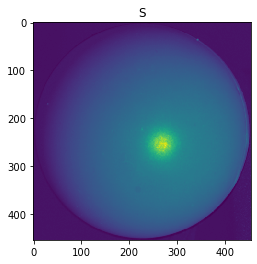

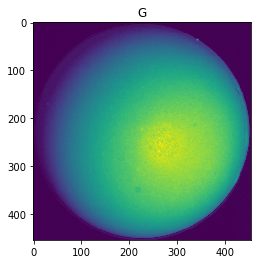

In [8]:
# PLOT FOR THE SPHERE

pickle_in = open("specular_sphere.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

# sample input
plot_specularity_removal(data['im1'], np.hstack((data["c"][0][0],
                                                 data["c"][1][0],
                                                 data["c"][2][0])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


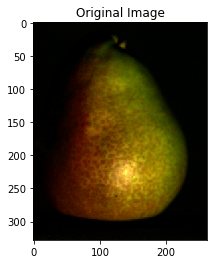

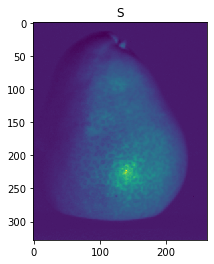

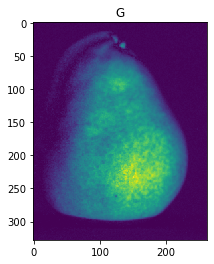

In [9]:
# PLOT FOR THE PEAR

pickle_in = open("specular_pear.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

# sample input
plot_specularity_removal(data['im1'], np.hstack((data["c"][0][0],
                                                 data["c"][1][0],
                                                 data["c"][2][0])))

### Part 3: Robust Photometric Stereo [6 pts]

Now we will perform photometric stereo on our sphere/pear images which include specularities. First, for comparison, run your photometric stereo code from 1a on the original images (converted to grayscale and rescaled/shifted to be in the range [0, 1]). You should notice erroneous "bumps" in the resulting reconstructions, as a result of violating the Lambertian assumption. For this, show the same outputs as in 1a.

Next, combine parts 1 and 2 by removing the specularities (using your code from 1b) and then running photometric stereo on the diffuse components of the specular sphere/pear images. Our goal will be to remove the bumps/sharp parts in the reconstruction.

For the specular sphere image set in `specular_sphere.pickle`, using all of the four images (again, be sure to convert them to grayscale and normalize them so that their values go from 0 to 1), include:

1. The estimated albedo map (original and diffuse).

1. The estimated surface normals (original and diffuse) by showing both

    1. Needle map, and
    1. Three images showing each of the surface normal components.
    
1. A wireframe of depth map (original and diffuse).

1. A wireframe of the depth map given by Horn integration (original and diffuse).

In total, we expect 2 \* 7 = 14 images for the 1a comparison, plus 2 \* 7 = 14 images for the outputs after specularity removal has been performed. (Thus 28 output images overall.)

In [10]:
from skimage import color

PLEASE NOTE THAT THE IMAGES BELOW ARE PLOTTED FOR BOTH WHEN THE DIRECTIONS OF THE DERIVATIVES ARE REVERSED OR NOT REVERSED.
------------------------------------------------------------------------------------------------------------------------------

/home/quan/miniconda3/envs/cse252a/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[0.08182257 0.0864081  0.08593584 ... 0.08251255 0.08586724 0.09153854]
 [0.08493973 0.08480063 0.08272494 ... 0.08575136 0.08848085 0.08689565]
 [0.08428475 0.08664029 0.08654664 ... 0.08525508 0.08855845 0.08503302]
 ...
 [0.08651367 0.09026896 0.08562754 ... 0.07766571 0.07527836 0.07163333]
 [0.08798729 0.0835235  0.08253819 ... 0.08718168 0.081223   0.06738818]
 [0.08593778 0.08513886 0.08007308 ... 0.08761771 0.08869912 0.07269649]]


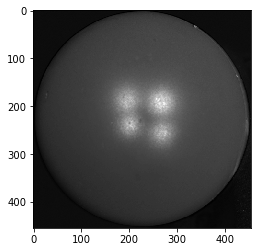

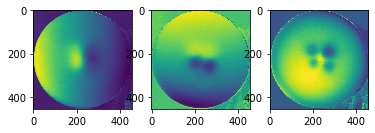

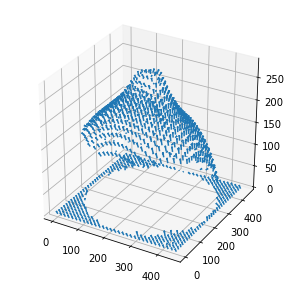

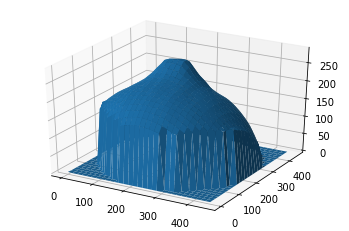

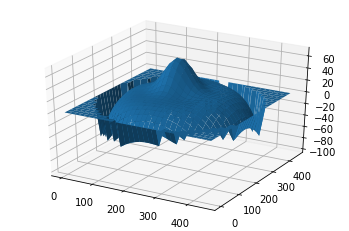

In [11]:
# SPHERE ORIGINAL IMAGE

# Load the images, normalize each one and save to data
# and also create the mask.
# Mask should be created by converting the images to grayscale, averaging them,
# normalizing to [0, 1] and thresholding

pickle_in = open("specular_sphere.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

mask = np.ones((455, 455), dtype=np.float32)

for im in ("im1", "im2", "im3", "im4"):
    grayscale = color.rgb2gray(data[im])
    data[im] = (grayscale - np.min(grayscale)) / (np.max(grayscale) - np.min(grayscale))

    mask += grayscale
    
mask = mask / 4.0
mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))
mask[mask < 0.1] = 0.0
mask[mask >= 0.1] = 1.0

lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im3"])
images.append(data["im4"])

images = np.array(images, dtype=np.float32)

# DO NOT REVERSE DERIVATIVE DIRECTION
# The plot below was obtained without reversing the direction of the derivative
albedo, normals, depth, horn = photometric_stereo(images, lights, mask, reverse_derivative=False, horn_niter=10000)

print(albedo)

visualize(albedo, normals, depth, horn)

/home/quan/miniconda3/envs/cse252a/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[0.08182257 0.0864081  0.08593584 ... 0.08251255 0.08586724 0.09153854]
 [0.08493973 0.08480063 0.08272494 ... 0.08575136 0.08848085 0.08689565]
 [0.08428475 0.08664029 0.08654664 ... 0.08525508 0.08855845 0.08503302]
 ...
 [0.08651367 0.09026896 0.08562754 ... 0.07766571 0.07527836 0.07163333]
 [0.08798729 0.0835235  0.08253819 ... 0.08718168 0.081223   0.06738818]
 [0.08593778 0.08513886 0.08007308 ... 0.08761771 0.08869912 0.07269649]]


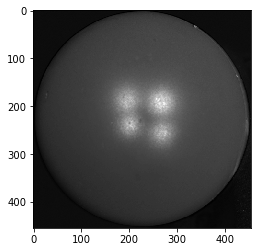

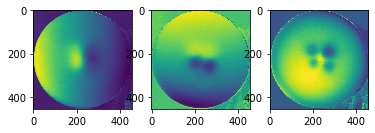

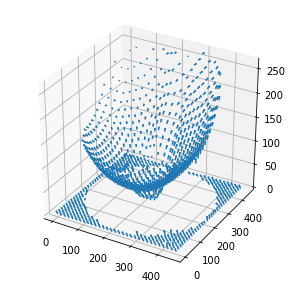

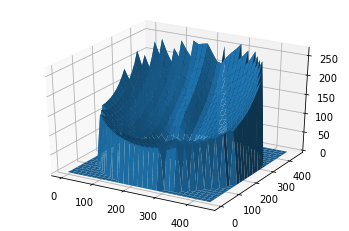

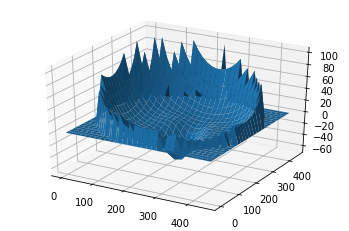

In [12]:
# REVERSE DERIVATIVE DIRECTION
# The plot below was obtained with reversing the direction of the derivative
albedo, normals, depth, horn = photometric_stereo(images, lights, mask, reverse_derivative=True, horn_niter=10000)

print(albedo)

visualize(albedo, normals, depth, horn)

/home/quan/miniconda3/envs/cse252a/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[0.00965674 0.00384462 0.00341603 ... 0.00640995 0.00507595 0.007073  ]
 [0.00337375 0.00392345 0.00482087 ... 0.00559216 0.00601878 0.00495398]
 [0.00429548 0.00660706 0.00345988 ... 0.00565319 0.00722824 0.00489295]
 ...
 [0.00910696 0.00686629 0.00326221 ... 0.01676281 0.00904856 0.00681099]
 [0.00910656 0.00560201 0.0049721  ... 0.01799878 0.01278156 0.00684476]
 [0.00980374 0.00414544 0.00631585 ... 0.01108021 0.00911092 0.01293805]]


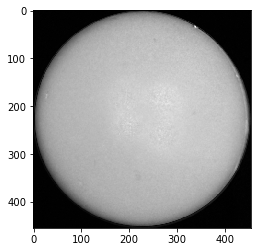

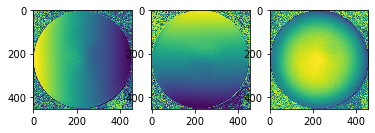

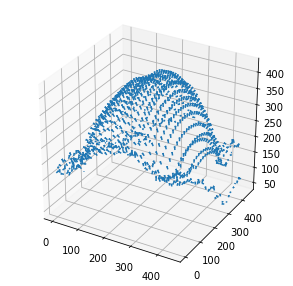

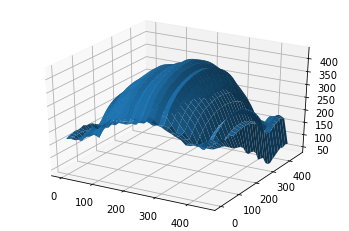

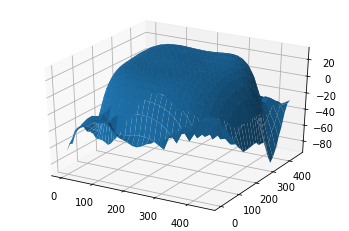

In [13]:
# SPHERE SPECULARITY REMOVED

pickle_in = open("specular_sphere.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

for im in ("im1", "im2", "im3", "im4"):

    _, G = RGBToSUV(data[im], np.hstack((data["c"][0][0],
                                         data["c"][1][0],
                                         data["c"][2][0])))
    data[im] = (G - np.min(G)) / (np.max(G) - np.min(G))

    
lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im3"])
images.append(data["im4"])
images = np.array(images, dtype=np.float32)

mask = np.ones(data["im1"].shape)

# DO NOT REVERSE DERIVATIVE DIRECTION
# The plot below was obtained without reversing the direction of the derivative
albedo, normals, depth, horn = photometric_stereo(images, lights, mask, reverse_derivative=False, horn_niter=10000)

print(albedo)

visualize(albedo, normals, depth, horn)

/home/quan/miniconda3/envs/cse252a/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[0.00965674 0.00384462 0.00341603 ... 0.00640995 0.00507595 0.007073  ]
 [0.00337375 0.00392345 0.00482087 ... 0.00559216 0.00601878 0.00495398]
 [0.00429548 0.00660706 0.00345988 ... 0.00565319 0.00722824 0.00489295]
 ...
 [0.00910696 0.00686629 0.00326221 ... 0.01676281 0.00904856 0.00681099]
 [0.00910656 0.00560201 0.0049721  ... 0.01799878 0.01278156 0.00684476]
 [0.00980374 0.00414544 0.00631585 ... 0.01108021 0.00911092 0.01293805]]


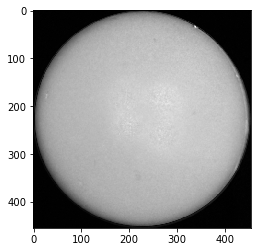

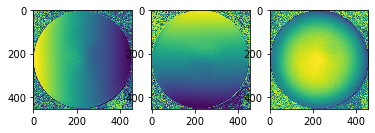

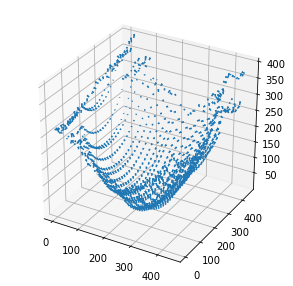

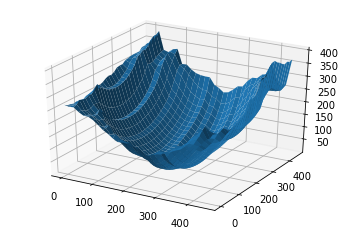

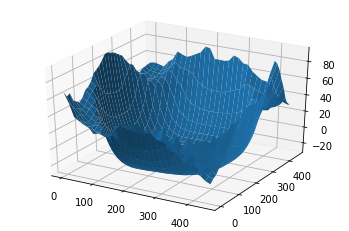

In [14]:
# REVERSE DERIVATIVE DIRECTION
# The plot below was obtained with reversing the direction of the derivative
albedo, normals, depth, horn = photometric_stereo(images, lights, mask, reverse_derivative=True, horn_niter=10000)

print(albedo)

visualize(albedo, normals, depth, horn)

/home/quan/miniconda3/envs/cse252a/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[0.10124801 0.09721371 0.10136358 ... 0.09492724 0.09248367 0.09261311]
 [0.10196829 0.09622001 0.10118449 ... 0.09687522 0.09389556 0.09307446]
 [0.09833892 0.09838002 0.09645751 ... 0.09651662 0.09509467 0.0940033 ]
 ...
 [0.08971508 0.09475043 0.11045594 ... 0.09670796 0.09919922 0.09736392]
 [0.09684838 0.09909205 0.11322822 ... 0.10220526 0.10623844 0.10318141]
 [0.10119812 0.10632741 0.10673098 ... 0.09573908 0.09755105 0.10386209]]


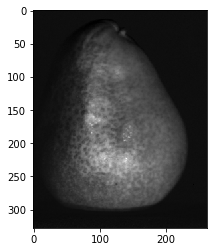

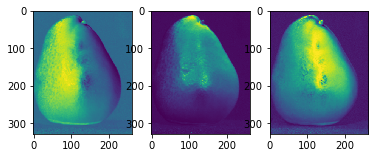

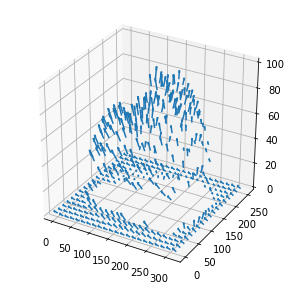

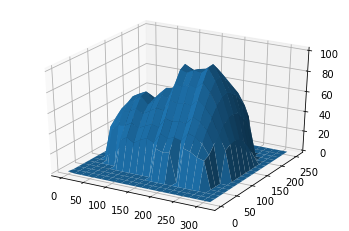

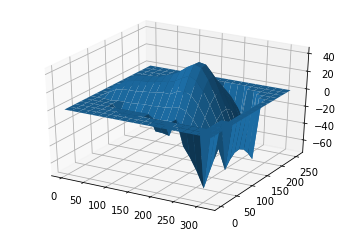

In [15]:
# PEARL ORIGINAL IMAGE

pickle_in = open("specular_pear.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

mask = np.ones((328, 262), dtype=np.float32)

for im in ("im1", "im2", "im3", "im4"):
    grayscale = color.rgb2gray(data[im])
    data[im] = (grayscale - np.min(grayscale)) / (np.max(grayscale) - np.min(grayscale))

    mask += grayscale
    
mask = mask / 4.0
mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))
mask[mask < 0.1] = 0.0
mask[mask >= 0.1] = 1.0

lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im3"])
images.append(data["im4"])
images = np.array(images)

# DO NOT REVERSE DERIVATIVE DIRECTION
# The plot below was obtained without reversing the direction of the derivative
albedo, normals, depth, horn = photometric_stereo(images, lights, mask, reverse_derivative=False, horn_niter=10000)

print(albedo)

visualize(albedo, normals, depth, horn)


/home/quan/miniconda3/envs/cse252a/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[0.10124801 0.09721371 0.10136358 ... 0.09492724 0.09248367 0.09261311]
 [0.10196829 0.09622001 0.10118449 ... 0.09687522 0.09389556 0.09307446]
 [0.09833892 0.09838002 0.09645751 ... 0.09651662 0.09509467 0.0940033 ]
 ...
 [0.08971508 0.09475043 0.11045594 ... 0.09670796 0.09919922 0.09736392]
 [0.09684838 0.09909205 0.11322822 ... 0.10220526 0.10623844 0.10318141]
 [0.10119812 0.10632741 0.10673098 ... 0.09573908 0.09755105 0.10386209]]


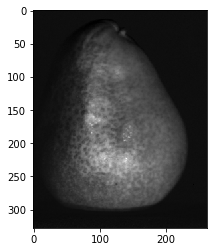

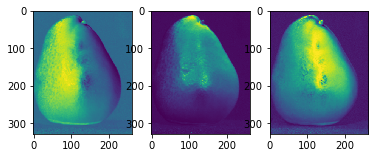

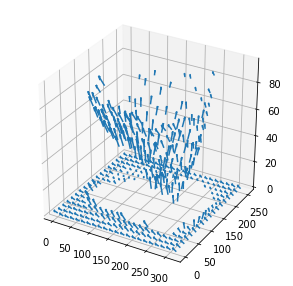

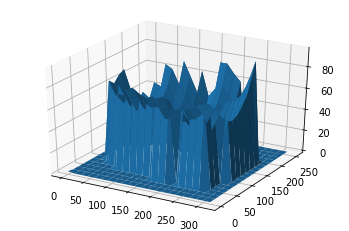

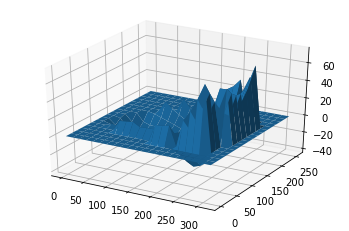

In [16]:
# REVERSE DERIVATIVE DIRECTION
# The plot below was obtained with reversing the direction of the derivative
albedo, normals, depth, horn = photometric_stereo(images, lights, mask, reverse_derivative=True, horn_niter=10000)

print(albedo)

visualize(albedo, normals, depth, horn)


/home/quan/miniconda3/envs/cse252a/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[0.01671655 0.01117761 0.01846296 ... 0.00706902 0.01222302 0.01089321]
 [0.01763942 0.01876915 0.01893778 ... 0.01138389 0.00586483 0.00700585]
 [0.01503537 0.01745137 0.00891238 ... 0.01115754 0.00547993 0.00396717]
 ...
 [0.01497523 0.01195032 0.02244363 ... 0.02168695 0.0181245  0.02084459]
 [0.01221953 0.0165051  0.01878369 ... 0.01982563 0.02459029 0.02757249]
 [0.02433663 0.01224921 0.01426221 ... 0.01457826 0.02031258 0.02464763]]


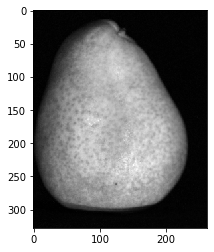

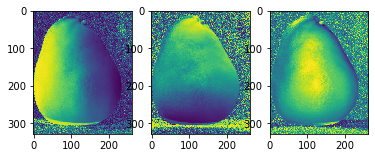

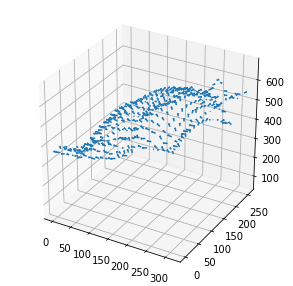

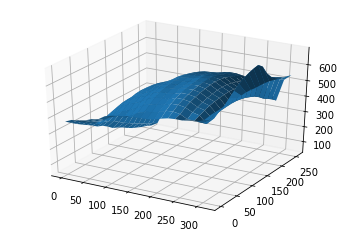

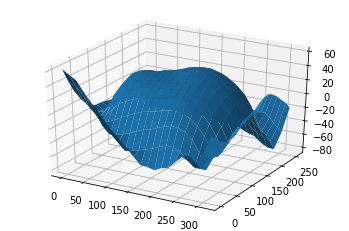

In [17]:
# PEAR SPECULARITY REMOVED

pickle_in = open("specular_pear.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

for im in ("im1", "im2", "im3", "im4"):

    _, G = RGBToSUV(data[im], np.hstack((data["c"][0][0],
                                         data["c"][1][0],
                                         data["c"][2][0])))
    data[im] = (G - np.min(G)) / (np.max(G) - np.min(G))
    
lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im3"])
images.append(data["im4"])
images = np.array(images)

mask = np.ones(data["im1"].shape)

# DO NOT REVERSE DERIVATIVE DIRECTION
# The plot below was obtained without reversing the direction of the derivative
albedo, normals, depth, horn = photometric_stereo(images, lights, mask, reverse_derivative=False, horn_niter=10000)

print(albedo)

visualize(albedo, normals, depth, horn)

/home/quan/miniconda3/envs/cse252a/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[0.01671655 0.01117761 0.01846296 ... 0.00706902 0.01222302 0.01089321]
 [0.01763942 0.01876915 0.01893778 ... 0.01138389 0.00586483 0.00700585]
 [0.01503537 0.01745137 0.00891238 ... 0.01115754 0.00547993 0.00396717]
 ...
 [0.01497523 0.01195032 0.02244363 ... 0.02168695 0.0181245  0.02084459]
 [0.01221953 0.0165051  0.01878369 ... 0.01982563 0.02459029 0.02757249]
 [0.02433663 0.01224921 0.01426221 ... 0.01457826 0.02031258 0.02464763]]


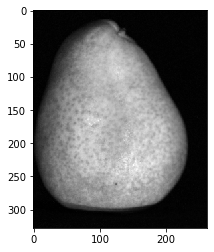

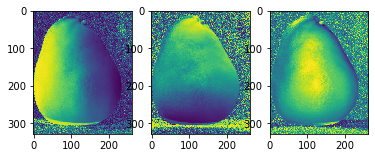

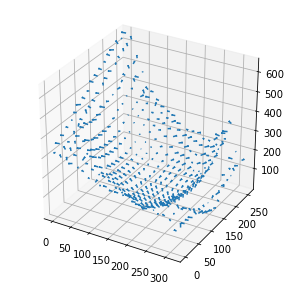

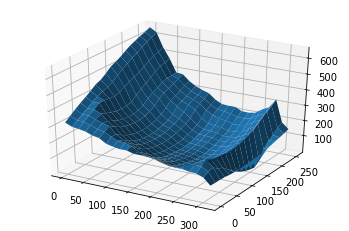

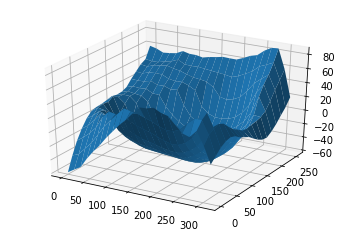

In [18]:
# REVERSE DERIVATIVE DIRECTION
# The plot below was obtained without reversing the direction of the derivative
albedo, normals, depth, horn = photometric_stereo(images, lights, mask, reverse_derivative=True, horn_niter=10000)

print(albedo)

visualize(albedo, normals, depth, horn)

## Problem 2: Image Filtering [13 pts]

### Part 1: Warmup [1.5 pts]

In this problem, we expect you to use convolution to filter the provided image with three different types of kernels:

1. A 5x5 Gaussian filter with $\sigma = 5$.
2. A 31x31 Gaussian filter with $\sigma = 5$.
3. A sharpening filter.

This is the image you will be using:

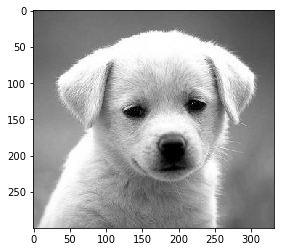

In [19]:
# Open image as grayscale
dog_img = io.imread('dog.jpg', as_gray=True)

# Show image
plt.imshow(dog_img, cmap='gray')
plt.show()

For convenience, we have provided a helper function for creating a square isotropic Gaussian kernel. We have also provided the sharpening kernel that you should use. Finally, we have provided a function to help you plot the original and filtered results side-by-side. Take a look at each of these before you move on.

In [20]:
def gaussian2d(filter_size=5, sig=1.0):
    """Creates a 2D Gaussian kernel with
    side length `filter_size` and a sigma of `sig`."""
    ax = np.arange(-filter_size // 2 + 1., filter_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
    return kernel / np.sum(kernel)

sharpening_kernel = np.array([
    [1, 4,     6,  4, 1],
    [4, 16,   24, 16, 4],
    [6, 24, -476, 24, 6],
    [4, 16,   24, 16, 4],
    [1,  4,    6,  4, 1],
]) * -1.0 / 256.0

def plot_results(original, filtered):
    # Plot original image
    plt.subplot(2,2,1)
    plt.imshow(original, vmin=0.0, vmax=1.0)
    plt.title('Original')
    plt.axis('off')

    # Plot filtered image
    plt.subplot(2,2,2)
    plt.imshow(filtered, vmin=0.0, vmax=1.0)
    plt.title('Filtered')
    plt.axis('off')

    plt.show()

Now fill in the functions below and display outputs for each of the filtering results. There should be three sets of (original, filtered) outputs in total. You are allowed to use the imported `convolve` function.

5x5 Gaussian filter, sigma=5


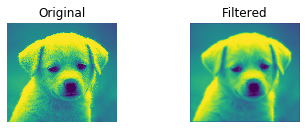

31x31 Gaussian filter, sigma=5


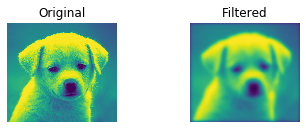

sharpening filter


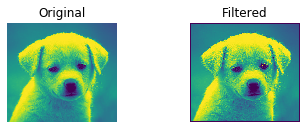

In [21]:
from scipy.signal import convolve

def filter1(img):
    """Convolve the image with a 5x5 Gaussian filter with sigma=5."""
    """ ==========
    YOUR CODE HERE
    ========== """
    f = gaussian2d(filter_size=5, sig=5.0)
    
    return convolve(img, f, mode='same')

def filter2(img):
    """Convolve the image with a 31x31 Gaussian filter with sigma=5."""
    """ ==========
    YOUR CODE HERE
    ========== """
    f = gaussian2d(filter_size=31, sig=5.0)
    
    return convolve(img, f, mode='same')

def filter3(img):
    """Convolve the image with the provided sharpening filter."""
    """ ==========
    YOUR CODE HERE
    ========== """
    return convolve(img, sharpening_kernel)

for filter_name, filter_fn in [
    ('5x5 Gaussian filter, sigma=5', filter1),
    ('31x31 Gaussian filter, sigma=5', filter2),
    ('sharpening filter', filter3),
]:
    filtered = filter_fn(dog_img)
    print(filter_name)
    plot_results(dog_img, filtered)

### Part 2 [2 pts]

Display the Fourier log-magnitude transform image for the (original image, 31x31 Gaussian-filtered image) pair. (No need to include the others.) We have provided the code to compute the Fourier log-magnitude image.

Then, as a text answer, explain the differences you see between the original frequency domain image and the 31x31 Gaussian-filtered frequency domain image. In particular, be sure to address the following points:
- Why is most of the frequency visualization dark after applying the Gaussian filter, and what does this signify?
- What is an example of one of these dark images in the spatial domain (original image)?
- What do the remaining bright regions in the magnitude image represent?
- What is an example of one of these bright regions in the spatial domain (original image)?

31x31 Gaussian filter, sigma=5


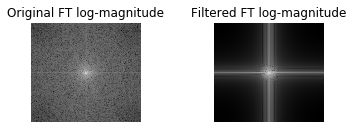

In [22]:
# Visualize the frequency domain images

def plot_ft_results(img1, img2):
    plt.subplot(2,2,1)
    plt.imshow(img1, cmap='gray')
    plt.title('Original FT log-magnitude')
    plt.axis('off')

    plt.subplot(2,2,2)
    plt.imshow(img2, cmap='gray')
    plt.title('Filtered FT log-magnitude')
    plt.axis('off')

    plt.show()

def ft_log_magnitude(img_gray):
    return np.log(np.abs(np.fft.fftshift(np.fft.fft2(img_gray))))

print('31x31 Gaussian filter, sigma=5')
plot_ft_results(ft_log_magnitude(dog_img), ft_log_magnitude(filter2(dog_img)))

### Your answer to Problem 2.2:

- Why is most of the frequency visualization dark after applying the Gaussian filter, and what does this signify? 

Most of the frequency is dark after applying the Gaussian filter because the Gaussian filter smoothes the images and removes high frequency components. This implies that a lot of the signal contained in the original image has high frequency.

- What is an example of one of these dark regions in the spatial domain (original image)? (Modifed question taken from piazza - post with titled 'Question about Problem 2 part 2')

An example is the area corresponding to the fur of the dog, which because of the texture of the fur, has high frequencies. The fur areas become significantly more blurry after the application of the Gaussian filter, indicating that the fine-grained details of the different hair become lost.

- What do the remaining bright regions in the magnitude image represent?

They represent the low frequency signal in the orignal image, which do not get smoothed into much lower frequency after the application of the Gaussian kernel.

- What is an example of one of these bright regions in the spatial domain (original image)?

They represent areas where the image gradient in the original image is relatively smooth over the size of the Gaussian kernel, such as the background behind the dog or the nose of the dog.

### Part 3 [3 pts]

Consider (1) smoothing an image with a 3x3 box filter and then computing the derivative in the y-direction (use the derivative filter from Lecture 7). Also consider (2) computing the derivative first, then smoothing. What is a single convolution kernel that will simultaneously implement both (1) and (2)?

### Your answer to Problem 2.3:

Because of the associativity property of convolution, we can convolve the derivative filter with the box filter to obtain another image. This image is a single convolution kernel that will simultaneously implement both (1) and (2).

Box filter: $$\frac{1}{9} \begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix}$$

Derivative filter in y direction: $$\begin{bmatrix} -\frac{1}{2} \\ 0 \\ \frac{1}{2} \end{bmatrix}$$

The resulting kernel is shown below:

In [23]:
box = np.ones((3, 3), dtype=np.float32) / 9.0
dev = np.array([[- 0.5], [0.0], [0.5]], dtype=np.float32)

print('box filter:')
print(box, box.shape, '\n')

print('derivative filter:')
print(dev, dev.shape, '\n')

print('(Computed using same mode) The single convolution kernel that we are looking for is:')
final = convolve(dev, box, mode='same')
print(final, final.shape, '\n')

print('(Computed using full mode) The single convolution kernel that we are looking for is:')
final = convolve(dev, box, mode='full')
print(final, final.shape, '\n')

box filter:
[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]] (3, 3) 

derivative filter:
[[-0.5]
 [ 0. ]
 [ 0.5]] (3, 1) 

(Computed using same mode) The single convolution kernel that we are looking for is:
[[-0.05555556]
 [ 0.        ]
 [ 0.05555556]] (3, 1) 

(Computed using full mode) The single convolution kernel that we are looking for is:
[[-0.05555556 -0.05555556 -0.05555556]
 [-0.05555556 -0.05555556 -0.05555556]
 [ 0.          0.          0.        ]
 [ 0.05555556  0.05555556  0.05555556]
 [ 0.05555556  0.05555556  0.05555556]] (5, 3) 



### Part 4 [3 pts]

Give an example of a 3x3 separable filter and compare the number of arithmetic operations it takes to
convolve using that filter on an n × n image before and after separation.

### Your answer to Problem 2.4:

Consider the Box filter: $\frac{1}{9} \begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix}$

This box filter can be separated into two 1-dimensional filter: $\frac{1}{9} \begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix} = \frac{1}{3}[1, 1, 1]^T * \frac{1}{3} [1, 1, 1]$.

Each time the box filter is applied, it is 8 add and 1 multiply. On a  n × n image, the filter would be applied (n-2) × (n-2) = $n^2 - 4n$ times, leading to $8n^2 - 32n$ add and $n^2 - 4n$ multiply.

Each time the 1-dimensional filter is applied, it is 2 add and 1 multiply. On a  n × n image, the filter would be applied (n-2) × n = $n^2 - 2n$ times. After applying the filter that is a column vector, the resulting image has dimension (n-2) × n. Convolving the remaining row vector filter with this image requires applying the filter (n-2) × (n-2) = $n^2 - 4n$ times. Thus, in total, we apply a 1-dim filter $2n^2 - 6n$ times, leading to $4n^2 - 12n$ add and $2n^2 - 6n$ multiply.

### Part 5: Filters as Templates [3.5 pts]

Suppose that you are a clerk at a grocery store. One of your responsibilites is to check the shelves periodically and stock them up whenever there are sold-out items. You got tired of this laborious task and decided to build a computer vision system that keeps track of the items on the shelf.

Luckily, you have learned in CSE 252A (or are learning right now) that convolution can be used for template matching: a template g is multiplied with regions of a larger image f to measure how similar each region is to the template. Note that you will want to flip the filter before giving it to your convolution function, so that it is overall not flipped when making comparisons. You will also want to subtract off the mean value of the image or template (whichever you choose, subtract the same value from both the image and template) so that your solution is not biased toward higher-intensity (white) regions.

The template of a product (template.jpg) and the image of the shelf (shelf.jpg) is provided. We will use convolution to find the product in the shelf.

<img src="template.jpg" alt="template" width="25px"/>
<img src="shelf.jpg" alt="shelf" width="600px"/>

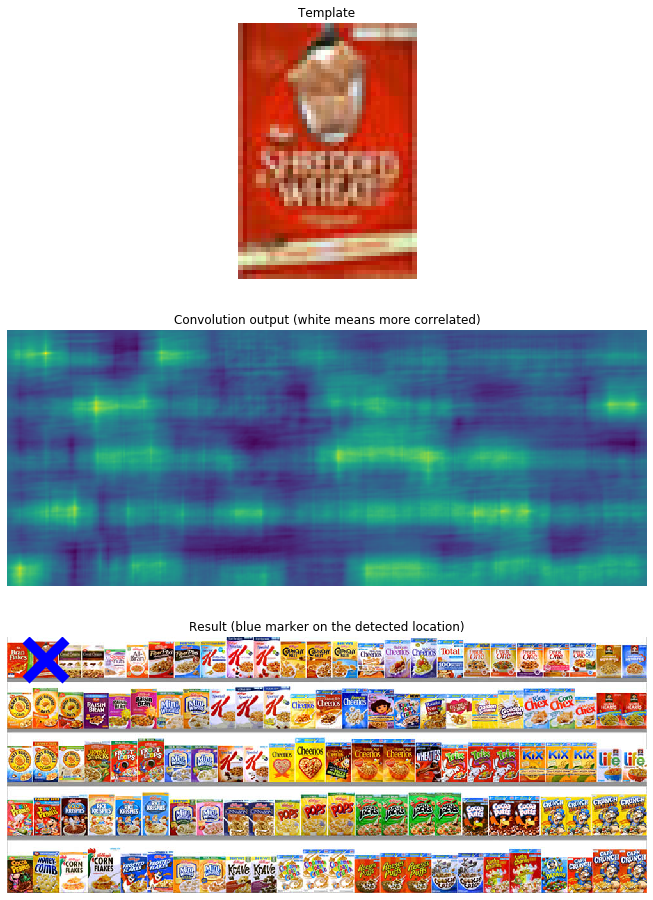

In [24]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from scipy.signal import convolve
%matplotlib inline
 
# Load template and image in grayscale
img = io.imread('shelf.jpg')
img_gray = io.imread('shelf.jpg', as_gray=True)
temp = io.imread('template.jpg')
temp_gray = io.imread('template.jpg', as_gray=True)

# Perform a convolution between the image and the template
""" ==========
YOUR CODE HERE
========== """
mean = np.mean(img_gray)
img_gray_normalized = img_gray - mean
temp_gray_normalized = temp_gray - mean

out = convolve(img_gray_normalized, np.flip(temp_gray_normalized), 
               mode='same', method='direct')

# Find the location with maximum similarity
y, x = (np.unravel_index(out.argmax(), out.shape))

# Display product template
plt.figure(figsize=(20,16))
plt.subplot(3, 1, 1)
plt.imshow(temp)
plt.title('Template')
plt.axis('off')

# Display convolution output
plt.subplot(3, 1, 2)
plt.imshow(out)
plt.title('Convolution output (white means more correlated)')
plt.axis('off')

# Display image
plt.subplot(3, 1, 3)
plt.imshow(img)
plt.title('Result (blue marker on the detected location)')
plt.axis('off')

# Draw marker at detected location
plt.plot(x, y, 'bx', ms=40, mew=10)
plt.show()

## Problem 3: Edge Detection [7 pts]

In this problem, you will write a function to perform edge detection. The following steps need to be implemented.

- **Smoothing [1 pt]:** First, we need to smooth the images to prevent noise from being considered edges. For this problem, use a 9x9 Gaussian kernel filter with $\sigma = 1.4$ to smooth the images.

- **Gradient Computation [2 pts]:** After you have finished smoothing, find the image gradient in the horizontal and vertical directions. Compute the gradient magnitude image as $|G| = \sqrt{G_x^2 + G_y^2}$.

- **Non-Maximum Suppression [4 pts]:** We would like our edges to be sharp, unlike the ones in the gradient magnitude image from above. Use local non-maximum suppression on the gradient magnitude image to suppress all local non-maximum gradient magnitude values. To see how it affects the results, try using two different window sizes: 5x5 and 21x21.

Compute the images after each step. Show each of the intermediate steps and label your images accordingly.

In total, there should be five output images (original, smoothed, gradient magnitude, NMS result with 5x5 window, NMS result with 21x21 window).

**For this question, use the image `geisel.jpeg`.**

Original:


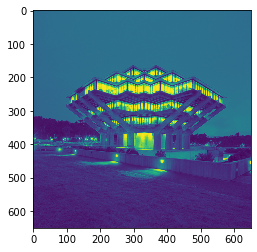

Smoothed:


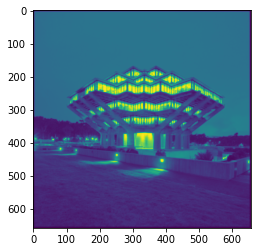

Gradient magnitude:


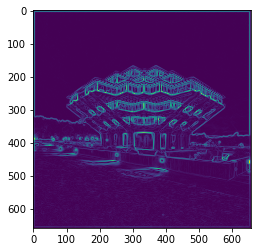

NMS with 5x5 window:


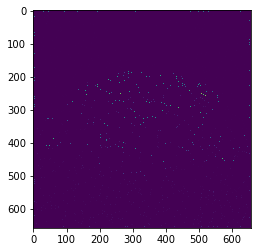

NMS with 21x21 window:


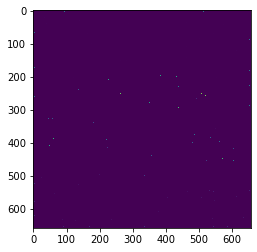

In [25]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

def smooth(image):
    """ ==========
    YOUR CODE HERE
    ========== """
    f = gaussian2d(9, 1.4)
    
    return convolve(image, f)

def gradient(image):
    """ ==========
    YOUR CODE HERE
    ========== """
    g_mag = np.zeros_like(image)
    g_theta = np.zeros_like(image)
    
    gx = convolve(image, [[-0.5, 0.0, 0.5]], mode='same')
    gy = convolve(image, [[-0.5], [0.0], [0.5]], mode='same')
    
    g_mag = np.sqrt(gx ** 2 + gy ** 2)
    g_theta = np.arctan(gy / gx)
    
    return g_mag, g_theta

def nms(g_mag, g_theta, window_size=5):
    
    # To perform nms, we adopt a sliding window approach.
    
    # For each pixel in the original image,
    # we compute a local patch in the image where the pixel is at the center.
    # The pixel value is suppressed if it is not the maximum value in the patch.
    
    # For pixel near the edge, it is not possible to obtain such patch
    # because some entries in the patch would go outside of the image.
    # To handle this scenarioes, we pad the image.

    suppressed = np.copy(g_mag)
    
    pad_size = int((window_size - 1) / 2)
    
    padded_img = np.pad(g_mag, 
                        pad_width=(pad_size, pad_size),
                        mode='constant',
                        constant_values=0)
    
    out = []
    
    # r and c stands for row and column
    
    # for each pixel in the padded img
    # except for the pixel added through padding
    for r_i in range(pad_size, padded_img.shape[0] - pad_size):
        for c_i in range(pad_size, padded_img.shape[1] - pad_size):
            
            # Obtain the patch coordinates
            patch_topleft_r = r_i - pad_size
            patch_topleft_c = c_i - pad_size
            
            patch_bottomright_r = r_i + pad_size
            patch_bottomright_c = c_i + pad_size
            
            
            # Check to see if the value at the pixel should be suppressed
            patch_max = np.max(
                padded_img[patch_topleft_r:patch_bottomright_r, patch_topleft_c:patch_bottomright_c]
            )
            
            if padded_img[r_i, c_i] >= patch_max:
                out.append(padded_img[r_i, c_i]) 
            else:
                out.append(0.0)
                
    # Reshape the output into the correct dimensions and shape
    out = np.array(out)
    out = np.reshape(out, newshape=g_mag.shape)
    
    return out

def edge_detect(image):
    """Perform edge detection on the image."""
    smoothed = smooth(image)
    g_mag, g_theta = gradient(smoothed)
    nms_image_5x5 = nms(g_mag, g_theta, window_size=5)
    nms_image_21x21 = nms(g_mag, g_theta, window_size=21)
    return smoothed, g_mag, nms_image_5x5, nms_image_21x21

# Load image in grayscale
image = io.imread('geisel.jpeg', as_gray=True)
smoothed, g_mag, nms_image_5x5, nms_image_21x21 = edge_detect(image)

print('Original:')
plt.imshow(image)
plt.show()

print('Smoothed:')
plt.imshow(smoothed)
plt.show()

print('Gradient magnitude:')
plt.imshow(g_mag)
plt.show()

print('NMS with 5x5 window:')
plt.imshow(nms_image_5x5)
plt.show()

print('NMS with 21x21 window:')
plt.imshow(nms_image_21x21)
plt.show()

---
## Submission Instructions
Remember to submit a PDF version of this notebook to Gradescope. Please make sure the contents of each cell are clearly shown in your final PDF file. **If they are not, we may dock points.**

There are multiple options for converting the notebook to PDF:
1. You can export using LaTeX (File $\rightarrow$ Download as $\rightarrow$ PDF via LaTeX).
2. You can first export as HTML and then save it as a PDF.